## - IMPORT LIBRAIRIES

In [19]:
#%matplotlib notebook

import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt

from pyunlocbox import functions, solvers
import pandas as pd
import networkx as nx
import random

## - LOAD ADJACENCY

In [2]:
adjacency = np.load('new_adjacency.npy')
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
degrees = sum(adjacency!=0)

## - GRAPH COMPUTING

In [3]:
G = nx.Graph()
G = nx.from_numpy_matrix(adjacency)

## - LAYOUT CHOICE

In [4]:
pos = nx.spring_layout(G)

## - GRAPH VISUALIZATION

C:\Users\Chris\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


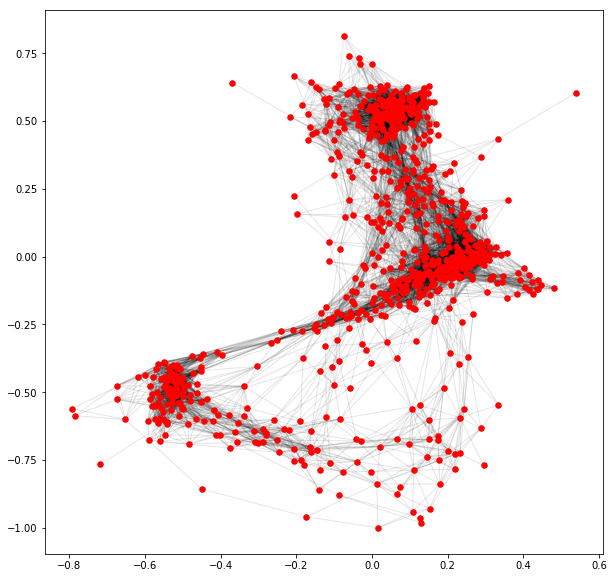

In [17]:
plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G, pos, node_size=30)
nx.draw_networkx_edges(G, pos, alpha =0.1)

## - NODE SELECTION

C:\Users\Chris\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


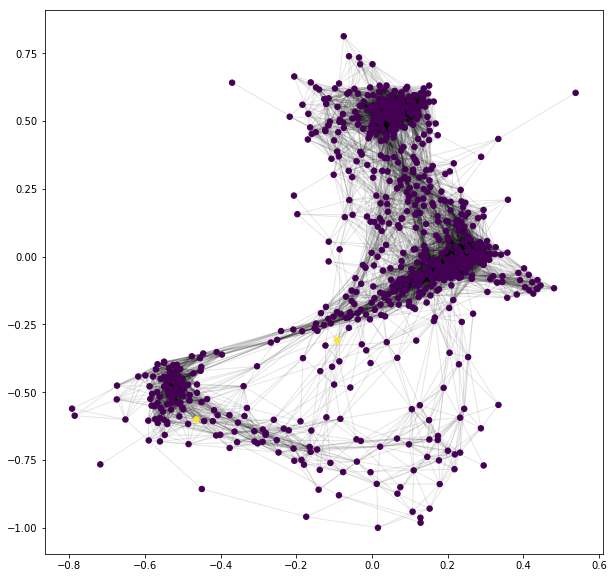

In [18]:
selected_nodes = [123, 400]

color = np.ones((n_nodes))
color[selected_nodes] = 5
plt.figure(figsize = (10,10))
nx.draw_networkx_nodes(G, pos, node_size=30, node_color=color)
nx.draw_networkx_edges(G, pos, alpha =0.1)

## - COMPUTE PATHS

The diameter of the graph gives the minimal length a playlist should have in order to link any pair of tracks in the graph.

In [7]:
nx.diameter(G)

10

In [9]:
def midpath_point_array(G, source, target):

    source_path_lengths = nx.single_source_dijkstra_path_length(G, source)
    target_path_lengths = nx.single_source_dijkstra_path_length(G, target)

    source_path_lengths_df = pd.DataFrame.from_dict(source_path_lengths, orient='index')\
                        .reset_index()\
                        .rename(columns = {'index':'node', 0:'length'})
    source_path_lengths_df.length = np.ceil(source_path_lengths_df.length)
    #all points at distance 4 from source
    source_path_lengths_df = source_path_lengths_df[source_path_lengths_df.length == 5].drop(columns=['length'])

    target_path_lengths_df = pd.DataFrame.from_dict(target_path_lengths, orient='index')\
                        .reset_index()\
                        .rename(columns = {'index':'node', 0:'length'})
    target_path_lengths_df.length = np.ceil(target_path_lengths_df.length)
    #all points at distance 5 from target
    target_path_lengths_df = target_path_lengths_df[target_path_lengths_df.length == 5].drop(columns=['length'])

    
    common_nodes = pd.merge(source_path_lengths_df, target_path_lengths_df, left_on='node', right_on='node')
    #midpath nodes is an array of nodes that can be used as a midpoint between start and target
    midpath_nodes = common_nodes.node.values
    return midpath_nodes

In [10]:
midpath_nodes = midpath_point_array(G, selected_nodes[0], selected_nodes[1])

In [60]:
midpath_nodes

array([773, 789, 498, 720, 107, 620,   5], dtype=int64)

In [65]:
#paths = nx.all_simple_paths(G, selected_nodes[0], selected_nodes[1], max_length)
#list_paths = list(paths)
#list_paths
midpath_rd = random.choice(midpath_nodes)
max_length = 5
paths_start_mid = nx.all_simple_paths(G, selected_nodes[0], midpath_rd, max_length)
paths_mid_target = nx.all_simple_paths(G, midpath_rd, selected_nodes[1], max_length)

print('First set of paths to the midpoint:\n')
for path in paths_start_mid:
    print(path)
print('\n Second set of paths from midpoint to target:\n')
for path in paths_mid_target:
    print(path)

First set of paths to the midpoint:

[123, 724, 37, 676, 148, 773]
[123, 724, 251, 114, 148, 773]
[123, 724, 251, 114, 198, 773]
[123, 724, 251, 114, 786, 773]
[123, 724, 251, 114, 788, 773]
[123, 724, 251, 220, 198, 773]
[123, 724, 690, 114, 148, 773]
[123, 724, 690, 114, 198, 773]
[123, 724, 690, 114, 786, 773]
[123, 724, 690, 114, 788, 773]
[123, 724, 690, 676, 148, 773]

 Second set of paths from midpoint to target:

[773, 148, 114, 251, 349, 400]
[773, 148, 676, 37, 743, 400]
[773, 198, 114, 251, 349, 400]
[773, 198, 220, 251, 349, 400]
[773, 198, 220, 547, 349, 400]
[773, 255, 206, 547, 349, 400]
[773, 255, 218, 98, 349, 400]
[773, 255, 218, 547, 349, 400]
[773, 255, 310, 98, 349, 400]
[773, 255, 310, 547, 349, 400]
[773, 786, 114, 251, 349, 400]
[773, 788, 114, 251, 349, 400]


In [12]:
#np.save('list_paths', list_paths)

## - COMPUTE SIGNAL

Compute the signal based on weight distribution on the paths

## - COMPUTE SMOOTHNESS

The smoothness of a signal can be computed by the quadratic form

$$ f^\intercal L f = \| \nabla_\mathcal{G} f \|_2^2 = \sum_{i \sim j} W_{ij} (f_j - f_i)^2 $$

In [13]:
import pylab
import math

class AnnoteFinder(object):
    """callback for matplotlib to display an annotation when points are
    clicked on.  The point which is closest to the click and within
    xtol and ytol is identified.
    
    Register this function like this:
    
    scatter(xdata, ydata)
    af = AnnoteFinder(xdata, ydata, annotes)
    connect('button_press_event', af)
    """

    def __init__(self, xdata, ydata, annotes, ax=None, xtol=None, ytol=None):
        self.data = list(zip(xdata, ydata, annotes))
        if xtol is None:
            xtol = ((max(xdata) - min(xdata))/float(len(xdata)))/2
        if ytol is None:
            ytol = ((max(ydata) - min(ydata))/float(len(ydata)))/2
        self.xtol = xtol
        self.ytol = ytol
        if ax is None:
            self.ax = plt.gca()
        else:
            self.ax = ax
        self.drawnAnnotations = {}
        self.links = []

    def distance(self, x1, x2, y1, y2):
        """
        return the distance between two points
        """
        return(math.sqrt((x1 - x2)**2 + (y1 - y2)**2))

    def __call__(self, event):

        if event.inaxes:

            clickX = event.xdata
            clickY = event.ydata
            if (self.ax is None) or (self.ax is event.inaxes):
                annotes = []
                # print(event.xdata, event.ydata)
                for x, y, a in self.data:
                    # print(x, y, a)
                    if ((clickX-self.xtol < x < clickX+self.xtol) and
                            (clickY-self.ytol < y < clickY+self.ytol)):
                        annotes.append(
                            (self.distance(x, clickX, y, clickY), x, y, a))
                if annotes:
                    annotes.sort()
                    distance, x, y, annote = annotes[0]
                    self.drawAnnote(event.inaxes, x, y, annote)
                    for l in self.links:
                        l.drawSpecificAnnote(annote)

    def drawAnnote(self, ax, x, y, annote):
        """
        Draw the annotation on the plot
        """
        if (x, y) in self.drawnAnnotations:
            markers = self.drawnAnnotations[(x, y)]
            for m in markers:
                m.set_visible(not m.get_visible())
            self.ax.figure.canvas.draw_idle()
        else:
            t = ax.text(x, y, " - %s" % (annote),)
            m = ax.scatter([x], [y], marker='d', c='r', zorder=100)
            self.drawnAnnotations[(x, y)] = (t, m)
            self.ax.figure.canvas.draw_idle()

    def drawSpecificAnnote(self, annote):
        annotesToDraw = [(x, y, a) for x, y, a in self.data if a == annote]
        for x, y, a in annotesToDraw:
            self.drawAnnote(self.ax, x, y, a)

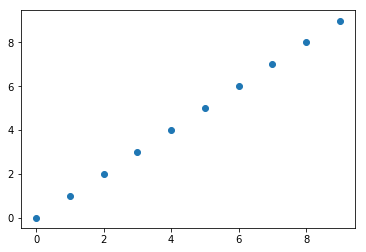

In [14]:
x = range(10)
y = range(10)
annotes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

fig, ax = plt.subplots()
ax.scatter(x,y)
af =  AnnoteFinder(x,y, annotes, ax=ax)
fig.canvas.mpl_connect('button_press_event', af)
plt.show()

C:\Users\Chris\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


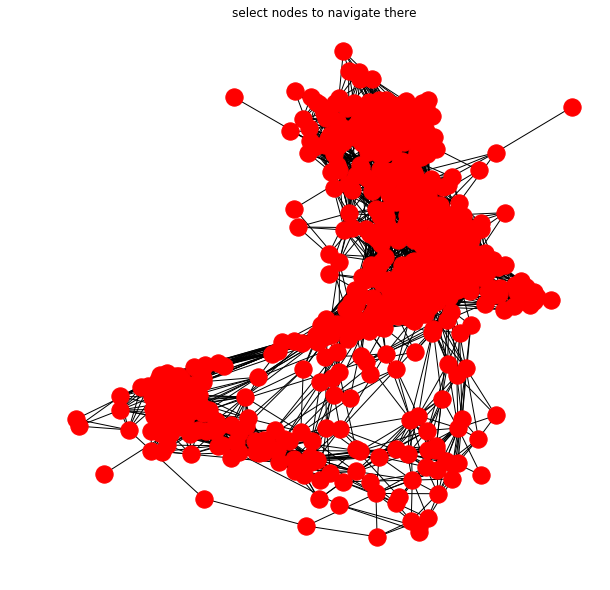

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('select nodes to navigate there')

x,y,annotes=[],[],[]

for key in pos:
    d=pos[key]
    annotes.append(key)
    x.append(d[0])
    y.append(d[1])

nx.draw(G,pos,font_size=8)

af = AnnoteFinder(x,y, annotes)
fig.canvas.mpl_connect('button_press_event', af)

plt.show()